## OHP He estimation from temperature measurements-two Hes- smooth varying He-averaged

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using DifferentialEquations


In [3]:
using Images

In [4]:
cd(dirname(pwd()))
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing


## Initialization

In [5]:
    ω0 = [sqrt(1.2e004)];
    ℘ = [1.2e005];


    Θ = 0.15;
    θe = 1 + Θ;
    θc = 1 - Θ;
    
    He = 3000.0;
    Hc = 3000.0;


    γ = 1.3;#not 1.4!!!!! maybe 1.33?

In [6]:
    L = 4.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    alpha = pi/2 # inclination angle 

1.5707963267948966

In [7]:
tube = Tube(L,L2D,alpha)

Tube(4.0, 2.0, 1.5707963267948966)

In [8]:
Xe = map(tuple, [0.0; 3.0], [1.0; 4.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)])

In [9]:
Xc = map(tuple, [1.0], [3.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)])

In [10]:
X0 = [(1.5,3.5)]
dXdt0 = [(0.0,0.0)]
liquids=LiquidSlug(γ,ω0,℘,X0,dXdt0)

LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)])

In [11]:
P = [1.0,1.0]

vapors=VaporPlug(γ,P)

VaporPlug(1.3, [1.0, 1.0])

In [12]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors)

PHPSystem(Tube(4.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)]), LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)]), VaporPlug(1.3, [1.0, 1.0]))

## Standard deviation

In [15]:
    function std_EnKF(estimation_state)

    matr_state = zeros(Float64, (length(estimation_state),length(estimation_state[1]),length(estimation_state[1][1])))
    
    # filter_state = zeros(length(estimation_state),size(estimation_state[1]))
    for i = 1:length(estimation_state)
        matr_state[i,:,:] = collect(deepcopy(hcat(estimation_state[i]...)'))
    end

    std_state = zeros(Float64, (length(estimation_state), length(estimation_state[1][1])))
    for i = 1:size(matr_state,1)
        for j = 1:size(matr_state,3)
            std_state[i,j] = std(matr_state[i,:,j])
        end
    end
    return std_state
end

std_EnKF (generic function with 1 method)

## Compress ensemble of ensembles

In [133]:
function compress_ens(ens_ensemble)

app = deepcopy(ens_ensemble[1])

for i in 2:size(ens_ensemble,1)
    for j in 1:size(ens_ensemble[1],1)
        append!(app[j],ens_ensemble[i][j])
    end
end

return app
end

compress_ens (generic function with 1 method)

## Get numerical solution

In [16]:
Lvaporplug = XptoLvaporplug(X0,L)
M = P.^(1/γ).* Lvaporplug

u=vcat(XMtovec(sys0.liquidslug.Xp,sys0.liquidslug.dXdt,M), He...)

7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

## Heaviside function

In [42]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))

heaviside (generic function with 1 method)

## EnKF PropagationFunction

In [43]:
function zhang2002modelEnKFtruth!(du::Array{Float64,1},uEnKF::Array{Float64,1},p::PHPSystem,t::Float64)

    sys = p

    # added He as a state vector entry
    u = uEnKF[1:end-1]
#     uHe = deepcopy(uEnKF[end]) + 9*deepcopy(uEnKF[end])*heaviside.(t-tspan[end]/2)
    uHe = deepcopy(uEnKF[end]) .* (sin(4*2*π*t/(tspan[end]))+1)

    numofliquidslug =  Integer( (length(u) - 1)/5 )
    
    (Xp,dXdt0,M)=vectoXM(u)

    γ = sys.liquidslug.γ
    ω0 = sys.liquidslug.ω0
    ℘ = sys.liquidslug.℘
    Lvaporplug = XptoLvaporplug(Xp,sys.tube.L)
#     Lliquidslug = XptoLliquidslug(Xp)
    height = getheight(Xp,sys.tube.L2D,sys.tube.alpha)
    Xpvapor = getXpvapor(Xp,sys.tube.L)


    P = real.((M./Lvaporplug .+ 0im).^(γ))

    θ = real.((P .+ 0im).^((γ-1)/γ))


    for i = 1:numofliquidslug
        du[2*i-1] = u[2*numofliquidslug+2*i-1]
        du[2*i] = du[2*i-1]

        du[2*numofliquidslug + 2*i-1] = -32*u[2*numofliquidslug + 2*i-1] - (ω0[i]^2)*(0.5*(height[i][end]-height[i][1])) + ℘[i]*(P[i]-P[i+1])
        du[2*numofliquidslug + 2*i] = du[2*numofliquidslug + 2*i-1]

    end


        du[4*numofliquidslug+1:5*numofliquidslug+1] .= dMdtzhang2002modelEnKF(Xpvapor,θ,sys,uHe)
    
    du[end]=0.0

    return du

end

zhang2002modelEnKFtruth! (generic function with 1 method)

In [44]:
function zhang2002modelEnKF!(du::Array{Float64,1},uEnKF::Array{Float64,1},p::PHPSystem,t::Float64)

    sys = p

    # added He as a state vector entry
    u = uEnKF[1:end-1]
    uHe = deepcopy(uEnKF[end])

    numofliquidslug =  Integer( (length(u) - 1)/5 )
    
    (Xp,dXdt0,M)=vectoXM(u)

    γ = sys.liquidslug.γ
    ω0 = sys.liquidslug.ω0
    ℘ = sys.liquidslug.℘
    Lvaporplug = XptoLvaporplug(Xp,sys.tube.L)
#     Lliquidslug = XptoLliquidslug(Xp)
    height = getheight(Xp,sys.tube.L2D,sys.tube.alpha)
    Xpvapor = getXpvapor(Xp,sys.tube.L)


    P = real.((M./Lvaporplug .+ 0im).^(γ))

    θ = real.((P .+ 0im).^((γ-1)/γ))


    for i = 1:numofliquidslug
        du[2*i-1] = u[2*numofliquidslug+2*i-1]
        du[2*i] = du[2*i-1]

        du[2*numofliquidslug + 2*i-1] = -32*u[2*numofliquidslug + 2*i-1] - (ω0[i]^2)*(0.5*(height[i][end]-height[i][1])) + ℘[i]*(P[i]-P[i+1])
        du[2*numofliquidslug + 2*i] = du[2*numofliquidslug + 2*i-1]

    end


        du[4*numofliquidslug+1:5*numofliquidslug+1] .= dMdtzhang2002modelEnKF(Xpvapor,θ,sys,uHe)
    
    du[end]=0.0

    return du

end


function dMdtzhang2002modelEnKF(Xpvapor::Array{Tuple{Float64,Float64},1},θ::Array{Float64,1},sys::PHPSystem,uHe)

    dMdt=zeros(length(Xpvapor))


    Xe = sys.evaporator.Xe
    He = uHe
    θe = sys.evaporator.θe

    Xc = sys.condenser.Xc
    Hc = sys.condenser.Hc
    θc = sys.condenser.θc

    Levapoverlap=XpvaportoLoverlap(Xpvapor,Xe)
    Lcondoverlap=XpvaportoLoverlap(Xpvapor,Xc)


    # May not be right for multi liquid flow
    for i = 1:length(Xpvapor)
        if Lcondoverlap[i] < 1e-8
            dMdt[i] = He * Levapoverlap[i] * (θe-θ[i])
        else
            dMdt[i] = -Hc * Lcondoverlap[i] * (θ[i]-θc)
        end
    end

    return dMdt

end

dMdtzhang2002modelEnKF (generic function with 1 method)

In [45]:
tstep=1.0e-5

p = sys0
tspan = (0.0, 0.1);
T = tspan[1]:tstep:tspan[end]

prob = ODEProblem(zhang2002modelEnKFtruth!, u, tspan, p)
sol = solve(prob, RK4(), adaptive=false, dt=tstep);
integrator = init(prob, RK4(), adaptive =false, dt = tstep, save_everystep=false)

t: 0.0
u: 7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

## EnKF

In [194]:
probEnKF = ODEProblem(zhang2002modelEnKF!, u, tspan, p)
solEnKF = solve(probEnKF, RK4(), adaptive=false, dt=tstep);
integrator = init(probEnKF, RK4(), adaptive =false, dt = tstep, save_everystep=false)

t: 0.0
u: 7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

In [195]:
newHe = 0.0

0.0

In [196]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
#         for j=1:10
        step!(integrator)
#         end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [197]:
fprop = PropagationFunction()

PropagationFunction()

In [198]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    result=soltoResult(s[1:end-1],sys0);
#     return [s[3]]
    return [deepcopy(result.θ[1]),deepcopy(result.θ[2])]
end

In [199]:
function (::MeasurementFunction)(t::Float64) 
#     return reshape([0.0, 0.0, 1.0, 0.0, 0.0, 0.0],(1,6))
    return reshape([1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0,0.0],(2,7))
end

In [200]:
m = MeasurementFunction()

MeasurementFunction()

In [201]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
#     fill!(ENS, [deepcopy(s[3])])
        result=soltoResult(s[1:end-1],sys0);
    fill!(ENS, [deepcopy(result.θ[1]),deepcopy(result.θ[2])])
    end
    return ENS
end

In [202]:
z = RealMeasurementFunction()

RealMeasurementFunction()

In [203]:
# A = MultiAdditiveInflation(2, 1.05, MvNormal(zeros(1), 2.0*I))
A = MultiAdditiveInflation(7, 1.001, MvNormal(zeros(7), 0.00001*Diagonal([1.0,1.0,100000.0,100000.0,1.0,1.0,1000000000000.0])))
# A = IdentityInflation()

MultiAdditiveInflation{7}(1.001, DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-5 0.0 … 0.0 0.0; 0.0 1.0e-5 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-5 0.0; 0.0 0.0 … 0.0 1.0e7]
)
)

In [204]:
# this is measurement noise!!!!!!!!
# ϵ = AdditiveInflation(MvNormal(zeros(1), 1.0*I))
ϵ = AdditiveInflation(MvNormal(zeros(2), 0.00001*I))

AdditiveInflation{2}(IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0e-5 0.0; 0.0 1.0e-5]
)
)

In [205]:
N = 30
# NZ = 1
NZ = 2
isinflated = true
isfiltered = false
isaugmented = true

true

In [206]:
g = FilteringFunction()

FilteringFunction()

In [207]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{30,2}(PropagationFunction(), MultiAdditiveInflation{7}(1.001, DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-5 0.0 … 0.0 0.0; 0.0 1.0e-5 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-5 0.0; 0.0 0.0 … 0.0 1.0e7]
)
), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{2}(IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0e-5 0.0; 0.0 1.0e-5]
)
), true, false, true)

In [208]:
Δt = 1e-5
Tsub = 0.0:Δt:0.1-Δt

times = 1:10
ens_ensemble = []

for i in times
    
x₀ = [1.0, 3.0, 0.0, 0.0, 1.0, 1.0, newHe]
ens = initialize(N, MvNormal(x₀, 1^2*Diagonal([1.0,1.0,100.0,100.0,1.0,1.0,500.0].^2)))
estimation_state = [deepcopy(ens.S)]

true_state = [deepcopy(x₀)]
covs = []
    
for (n,t) in enumerate(Tsub)

    global ens
    
    t, ens, cov = enkf(t, Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    push!(covs, deepcopy(cov))
    

end
    push!(ens_ensemble, deepcopy(estimation_state))
    println("i= ",i)
end

i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10


In [209]:
compress_state = compress_ens(ens_ensemble);

In [210]:
std_state = std_EnKF(compress_state);

## Show the results

In [211]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(compress_state)...)

results=soltoResult(sol[1:end-1,:],sys0);
resultŝ=soltoResult(ŝ[1:end-1,:],sys0);



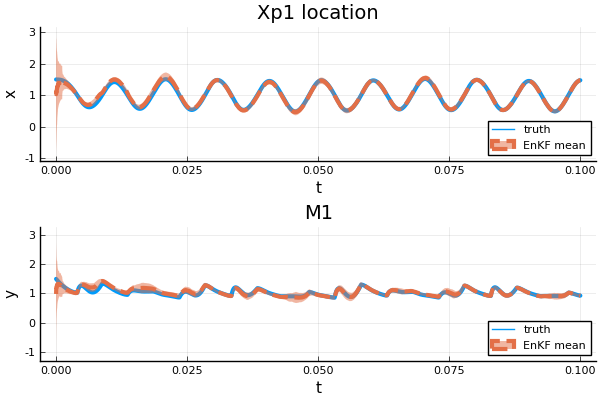

In [212]:
plt1 = plot(layout = (2, 1), legend = :bottomright)
plot!(plt1[1], T, results.Xp[1][1:end-1], linewidth = 3, label = "truth")
plot!(plt1[1], Tsub, ŝ[1,1:end-1], linewidth = 3,ribbon = 2*std_state[:,1], markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash,title="Xp1 location")

plot!(plt1[2], T, results.M[1][1:end-1], linewidth = 3, label = "truth")
plot!(plt1[2], Tsub,  ŝ[5,1:end-1], linewidth = 3,ribbon = 2*std_state[:,5], markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash,title="M1")

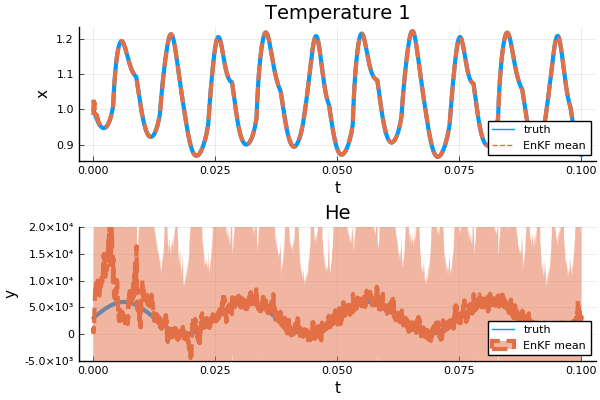

In [213]:
plt2 = plot(layout = (2, 1), legend = :bottomright)

plot!(plt2[1], T, results.θ[1][1:end-1], linewidth = 3, label = "truth")
plot!(plt2[1], Tsub, resultŝ.θ[1][1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash,title="Temperature 1")

plot!(plt2[2], T, (sol[end,1:end-1] .* (sin.(4*2*π.*T./(T[end])) .+ 1)), linewidth = 3, label = "truth")
plot!(plt2[2], Tsub, ŝ[7,1:end-1], linewidth = 3, markersize = 2, ribbon = 2*std_state[:,7], label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash,title="He", ylim=(-5000.0, 20000.0))
# plot!(plt2[2], T, (sol[end,1:end-1] .* (sin.(4*2*π.*T./(T[end])) .+ 1)), linewidth = 3, label = "truth")

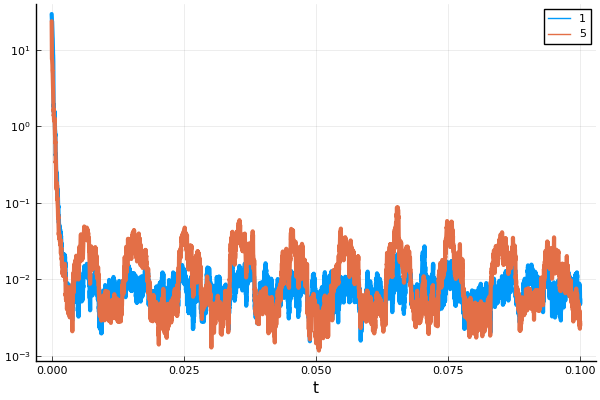

In [214]:
plot(Tsub, map(covs) do P  
        P[1,1]+ eps() end, yscale = :log10, linewidth = 3, label = "1")
plot!(Tsub, map(covs) do P
        P[5,5]+ eps() end, yscale = :log10, linewidth = 3, xlabel = "t", label = "5")